In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import math
import onnxruntime as rt

In [2]:
def build_input_data(sess, data):
    """
    Builds the input_data dictionary for ONNX inference.

    Parameters:
    - sess: onnxruntime.InferenceSession, the ONNX model session.
    - data: pandas.DataFrame or dict-like, the input data.

    Returns:
    - input_data: dict, formatted input data for the ONNX model.
    """
    input_data = {}

    for input_tensor in sess.get_inputs():
        name = input_tensor.name
        shape = input_tensor.shape  # Shape of the expected input (e.g., [None, 1])
        data_type = input_tensor.type  # Expected data type (e.g., 'tensor(float)', 'tensor(string)')

        # Extract the column from the input data
        column_data = data[name]

        # Ensure it's in the correct format
        if "float" in data_type.lower():
            input_data[name] = np.array(column_data).astype(np.float32).reshape(-1, shape[1] if len(shape) > 1 else 1)
        elif "string" in data_type.lower():
            input_data[name] = np.array(column_data).astype(str).reshape(-1, shape[1] if len(shape) > 1 else 1)
        elif "int64" in data_type.lower():
            input_data[name] = np.array(column_data).astype(np.int64).reshape(-1, shape[1] if len(shape) > 1 else 1)
        else:
            raise ValueError(f"Unsupported data type for input '{name}': {data_type}")

    return input_data


In [3]:
#change to model_1 to run Model 1
new_session = rt.InferenceSession("Model/model_2.onnx")

In [4]:
df = pd.read_csv("investigation_train_large_checked.csv", na_values='?')
df.head()

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,Ja,Nee,checked
0,1,1,0,0,23240,1,0,0,0,0,...,1,0,0,0,0,0,0,0.617698,0.382302,False
1,4,2,1,1,1971,1,0,0,1,0,...,1,0,1,0,1,0,0,0.602167,0.397833,False
2,6,4,2,1,7247,0,0,0,1,0,...,1,0,1,0,0,0,0,0.512377,0.487623,False
3,3,2,0,1,8060,1,0,0,1,0,...,1,0,0,0,0,0,0,0.717796,0.282204,True
4,3,2,0,0,18705,1,0,0,0,0,...,1,0,1,0,0,0,0,0.705484,0.294516,True


In [5]:
X = df.drop(['checked', 'Ja', 'Nee'],  axis=1)
y = df['checked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
input_data = build_input_data(new_session, X_test)

# Perform inference using the ONNX model
result = new_session.run(None, input_data)[0]

In [7]:
print(result.shape)

(32500,)


In [8]:
# save the test data as a csv file
X_test_df = pd.DataFrame(X_test, columns=X.columns) 

y_test_df = pd.DataFrame(y_test, columns=["checked"]) 

X_test_df = X_test_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

test_df = pd.concat([X_test_df, y_test_df], axis=1)

print(test_df.shape)

(32500, 316)


In [9]:
sensitive_features = ["adres_dagen_op_adres", "adres_recentste_buurt_groot_ijsselmonde", "adres_recentste_buurt_nieuwe_westen", "adres_recentste_buurt_other", "adres_recentste_buurt_oude_noorden", "adres_recentste_buurt_vreewijk", "adres_recentste_plaats_other", "adres_recentste_plaats_rotterdam", "adres_recentste_wijk_charlois", "adres_recentste_wijk_delfshaven", "adres_recentste_wijk_feijenoord", "adres_recentste_wijk_ijsselmonde", "adres_recentste_wijk_kralingen_c", "adres_recentste_wijk_noord", "adres_recentste_wijk_other", "adres_recentste_wijk_prins_alexa", "adres_recentste_wijk_stadscentru", "afspraak_aantal_woorden", "afspraak_afgelopen_jaar_monitoring_insp__wet_taaleis_na_12_mnd_n_a_v__taa04_____geen_maatregel", "afspraak_afgelopen_jaar_ontheffing_taaleis", "afspraak_laatstejaar_aantal_woorden", "afspraak_verzenden_beschikking_i_v_m__niet_voldoen_aan_wet_taaleis", "belemmering_dagen_lichamelijke_problematiek", "belemmering_dagen_psychische_problemen", "belemmering_hist_lichamelijke_problematiek", "belemmering_hist_psychische_problemen", "belemmering_hist_taal", "belemmering_hist_verslavingsproblematiek", "belemmering_niet_computervaardig", "belemmering_psychische_problemen", "beschikbaarheid_aantal_historie_afwijkend_wegens_medische_omstandigheden", "beschikbaarheid_huidig_afwijkend_wegens_medische_omstandigheden", "beschikbaarheid_recent_afwijkend_wegens_medische_omstandigheden", "competentie_vakdeskundigheid_toepassen", "contacten_onderwerp_beoordelen_taaleis", "contacten_onderwerp_boolean_beoordelen_taaleis", "contacten_onderwerp_boolean_taaleis___voldoet", "contacten_onderwerp_boolean_ziek__of_afmelding", "contacten_onderwerp_boolean_zorg", "contacten_onderwerp_ziek__of_afmelding", "contacten_onderwerp_zorg", "instrument_aantal_laatstejaar", "ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden", "ontheffing_reden_hist_medische_gronden", "persoon_geslacht_vrouw", "persoon_leeftijd_bij_onderzoek", "persoonlijke_eigenschappen_dagen_sinds_taaleis", "persoonlijke_eigenschappen_nl_begrijpen3", "persoonlijke_eigenschappen_nl_lezen3", "persoonlijke_eigenschappen_nl_lezen4", "persoonlijke_eigenschappen_nl_schrijven0", "persoonlijke_eigenschappen_nl_schrijven1", "persoonlijke_eigenschappen_nl_schrijven2", "persoonlijke_eigenschappen_nl_schrijven3", "persoonlijke_eigenschappen_nl_schrijvenfalse", "persoonlijke_eigenschappen_nl_spreken1", "persoonlijke_eigenschappen_nl_spreken2", "persoonlijke_eigenschappen_nl_spreken3", "persoonlijke_eigenschappen_spreektaal", "persoonlijke_eigenschappen_spreektaal_anders", "persoonlijke_eigenschappen_taaleis_schrijfv_ok", "persoonlijke_eigenschappen_taaleis_voldaan", "relatie_kind_basisschool_kind", "relatie_kind_heeft_kinderen", "relatie_kind_huidige_aantal", "relatie_kind_jongvolwassen", "relatie_kind_tiener", "relatie_kind_volwassen", "relatie_overig_actueel_vorm__kostendeler", "relatie_overig_actueel_vorm__ouders_verzorgers", "relatie_overig_historie_vorm__andere_inwonende", "relatie_overig_historie_vorm__kostendeler", "relatie_overig_kostendeler", "relatie_partner_aantal_partner___partner__gehuwd_", "relatie_partner_aantal_partner___partner__ongehuwd_", "relatie_partner_huidige_partner___partner__gehuwd_", "relatie_partner_totaal_dagen_partner"
]

In [10]:
unique_subgroups = {}
for k in sensitive_features:
    unique_subgroups[k] = test_df[k].unique().tolist()

In [11]:
pred_column = result
test_df['Prediction'] = pred_column

print(test_df.shape)

(32500, 317)


Fairness Testing for all sensitive features

In [12]:
#false positive - actual - false and prediction - true
#false negative - actual - true and prediction - false
#true positive - actual - true and prediction -true
#true negative - actual - false and prediction - false

In [45]:
def statistical_parity(feature, categories, df):
    results = {}
    if len(categories)>2: 
        # mean_val = np.mean(df[feature])
        if feature == 'persoon_leeftijd_bij_onderzoek':
            mean_val = -1.9034432
        else:
            mean_val = np.mean(df[feature]) 
        category_labels = ["less_than_mean", "greater_than_mean"]
        df["subgroups"] = np.where(df[feature] <= mean_val, category_labels[0], category_labels[1])
    else:  
        df["subgroups"] = df[feature]
    grouped = df.groupby("subgroups")
    for group, data in grouped:
        positives = ((data["Prediction"] == 1)).sum()
        all = ((data["Prediction"] == 1) | (data["Prediction"] == 0)).sum()
        result = positives / all
        results[(feature, group)] = result
    return results

In [29]:
sp_dict = {}
for feature, categories in unique_subgroups.items():
    stats = statistical_parity(feature, categories, test_df)
    sp_dict.update(stats)
print(sp_dict.keys())

153


In [27]:
# df = pd.DataFrame([
#     {"Feature": feature, "Category": category, "Value": value}
#     for (feature, category), value in sp_dict.items()
# ])
# 
# # Save to CSV file
# csv_filename = "sp_dict_model2.csv"
# df.to_csv(csv_filename, index=False)
# 
# print(f"CSV file '{csv_filename}' saved successfully!")

CSV file 'sp_dict_model2.csv' saved successfully!


Partition Testing

In [28]:
def statistical_parity_parition(feature1, feature2, df):
    results = {}
    df[f"{feature1}_group"] = np.where(df[feature1] == 0, "male", "female")
    # df[f"{feature1}_group"] = np.where(df[feature1] == 0, "notFluent", "fluent")
    # df[f"{feature2}_group"] = np.where(df[feature2] == 0, "unmarried", "married")
    df[f"{feature2}_group"] = np.where(df[feature2] <= np.mean(df[feature2]), "lessAppointment", "moreAppointment")
    df["combined_subgroups"] = df[[f"{feature1}_group", f"{feature2}_group"]].apply(
        lambda row: f"{row[0]}_{row[1]}", axis=1
    )  #would result in feature1_feature2 --> less_greater

    unique_combinations = set()
    grouped = df.groupby("combined_subgroups")
    
    for group, data in grouped:
        parts = group.split("_")
        if group in unique_combinations or "_".join(reversed(parts)) in unique_combinations:
            continue
        if parts[0] == parts[1]:
            continue
        unique_combinations.add(group)
        positives = ((data["Prediction"] == 1)).sum()
        all = ((data["Prediction"] == 1) | (data["Prediction"] == 0)).sum()
        result = positives / all
        results[(group)] = result
        
    return results

In [29]:
#replace feature names to compute the parition statistical parity values
results = statistical_parity_parition("persoon_geslacht_vrouw", "afspraak_afgelopen_jaar_ontheffing_taaleis", test_df)
print(results)

C:\Users\HP Zbook\AppData\Local\Temp\ipykernel_42392\3813072749.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda row: f"{row[0]}_{row[1]}", axis=1


{'female_lessAppointment': 0.0446465768643244, 'female_moreAppointment': 0.02736842105263158, 'male_lessAppointment': 0.050110922615163776, 'male_moreAppointment': 0.03192279138827023}


In [ ]:
fig, ax = plt.subplots()
ax.bar(results.keys(), results.values(), color='blue')
ax.set_ylabel('Values')
ax.set_title('Appointment Data Visualization')
ax.tick_params(axis='x', labelrotation=45, labelbottom=True)  
plt.show()

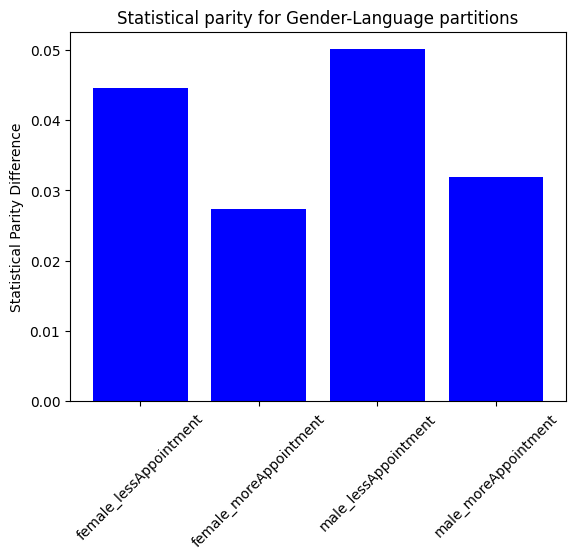

In [30]:
#difference between each partitions
diff = abs(results["fluent_married"] - results["fluent_unmarried"])
print("diff fluent_married-fluent_unmarried", diff)
diff1 = abs(results["notFluent_married"] - results["notFluent_unmarried"])
print("diff notFluent_married-notFluent_unmarried", diff1)
diff2 = abs(results["fluent_married"] - results["notFluent_married"])
print("diff fluent_married-notFluent_married", diff2)
diff3 = abs(results["fluent_unmarried"] - results["notFluent_unmarried"])
print("diff fluent_unmarried-notFluent_unmarried", diff3)
diff4 = abs(results["fluent_married"] - results["notFluent_unmarried"])
print("diff fluent_married-notFluent_unmarried", diff4)
diff5 = abs(results["notFluent_married"] - results["fluent_unmarried"])
print("diff notFluent_married-fluent_unmarried", diff5)

In [16]:
differences = {
    "fluent_married-fluent_unmarried": abs(results["fluent_married"] - results["fluent_unmarried"]),
    "notFluent_married-notFluent_unmarried": abs(results["notFluent_married"] - results["notFluent_unmarried"]),
    "fluent_married-notFluent_married": abs(results["fluent_married"] - results["notFluent_married"]),
    "fluent_unmarried-notFluent_unmarried": abs(results["fluent_unmarried"] - results["notFluent_unmarried"]),
    "fluent_married-notFluent_unmarried": abs(results["fluent_married"] - results["notFluent_unmarried"]),
    "notFluent_married-fluent_unmarried": abs(results["notFluent_married"] - results["fluent_unmarried"])
}

# Print the dictionary (Optional)
print(differences)

KeyError: 'fluent_married'

In [17]:
df = pd.DataFrame(list(differences.items()), columns=["Comparison", "Difference"])

# Save as CSV file
csv_filename = "partition_testing/statistical_parity_speaking_maritalStatus_model2.csv"
df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' saved successfully!")